In [22]:
import requests
import zipfile
from arcpy.sa import *

In [23]:
#url for land cover data for Minnesota
landcover_url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2019/tif_biota_landcover_nlcd_mn_2019.zip'

In [24]:
#make API request
response = requests.get(landcover_url)

In [25]:
#write land cover data to a file
with open('C:/Users/tjjoh/Documents/GIS5571/landcover.zip', 'wb') as file:
    file.write(response.content)

In [26]:
#unzip the land cover file
with zipfile.ZipFile('C:/Users/tjjoh/Documents/GIS5571/landcover.zip', 'r') as zip_ref:
    zip_ref.extractall('C:/Users/tjjoh/Documents/GIS5571/landcover')

In [27]:
#clip the data to a reasonable extent
arcpy.management.Clip(
    in_raster=r"C:\Users\tjjoh\Documents\GIS5571\landcover\NLCD_2019_Land_Cover.tif",
    rectangle="564956.185 4872190.574 580163.185 4889707.574",
    out_raster=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\LandCover_Clip",
    in_template_dataset=None,
    nodata_value="3.4e+38",
    clipping_geometry="NONE",
    maintain_clipping_extent="NO_MAINTAIN_EXTENT"
)

<Result 'C:\\Users\\tjjoh\\Documents\\GIS5571\\Lab2_GDB.gdb\\LandCover_Clip'>

In [28]:
#url for DEM of Minnesota
dem_url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/elev_30m_digital_elevation_model/fgdb_elev_30m_digital_elevation_model.zip'

In [29]:
#make API request
response = requests.get(dem_url)

In [30]:
#write DEM to a file
with open('C:/Users/tjjoh/Documents/GIS5571/dem.zip', 'wb') as file:
    file.write(response.content)

In [31]:
#unzip the DEM file
with zipfile.ZipFile('C:/Users/tjjoh/Documents/GIS5571/dem.zip', 'r') as zip_ref:
    zip_ref.extractall('C:/Users/tjjoh/Documents/GIS5571/dem')

In [32]:
#calculate slope from the DEM
arcpy.ddd.Slope(
    in_raster=r"C:\Users\tjjoh\Documents\GIS5571\dem\elev_30m_digital_elevation_model.gdb\digital_elevation_model_30m",
    out_raster=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Slope",
    output_measurement="DEGREE",
    z_factor=1,
    method="PLANAR",
    z_unit="METER",
    analysis_target_device="GPU_THEN_CPU"
)

<Result 'C:\\Users\\tjjoh\\Documents\\GIS5571\\Lab2_GDB.gdb\\Slope'>

In [33]:
#clip the data to a reasonable extent
arcpy.management.Clip(
    in_raster=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Slope",
    rectangle="564956.185 4872190.574 580163.185 4889707.574",
    out_raster=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Slope_Clip",
    in_template_dataset=None,
    nodata_value="3.4e+38",
    clipping_geometry="NONE",
    maintain_clipping_extent="NO_MAINTAIN_EXTENT"
)

<Result 'C:\\Users\\tjjoh\\Documents\\GIS5571\\Lab2_GDB.gdb\\Slope_Clip'>

In [34]:
#define variable names
slope = r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Slope_Clip"
landcover = r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\LandCover_Clip"

In [35]:
#rescale the slope on a 0 to 1 scale by dividing by 90
rescaled_slope = RasterCalculator(rasters = [slope], 
                                  input_names = ['x'], 
                                  expression = 'x/90'
                                 )

In [36]:
#create a raster where agricultural areas have value 1 and oll other areas have value 0
agricultural = RasterCalculator(rasters = [landcover],
                                input_names = ['x'],
                                expression = 'x == 82'
                               )

In [37]:
#create a raster where water has value 1 and all other areas have value 0
water = RasterCalculator(rasters = [landcover],
                         input_names = ['x'],
                         expression = '(x == 11) | (x == 12) | (x == 90) | (x == 95)'
                        )

In [38]:
#Create cost surface
cost_surface = RasterCalculator(rasters = [rescaled_slope, agricultural, water],
                                input_names = ['x','y','z'],
                                expression = 'x/3 + y/3 + z/3'
                               )

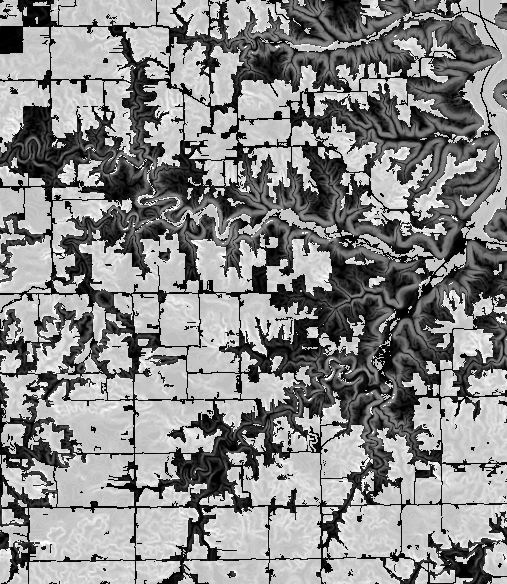

In [40]:
cost_surface

In [39]:
#Generate optimal route
arcpy.sa.OptimalRegionConnections(
    in_regions=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Endpoints",
    out_feature_class=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Optimal_111",
    in_barrier_data=None,
    in_cost_raster=cost_surface,
    out_neighbor_paths=None,
    distance_method="PLANAR",
    connections_within_regions="GENERATE_CONNECTIONS"
)

<geoprocessing server result object object at 0x00000246AFB3AED0>

In [44]:
#Create cost surface where Dory really doesn't want to go through farm fields, but is somewhat okay with water
cost_surface = RasterCalculator(rasters = [rescaled_slope, agricultural, water],
                                input_names = ['x','y','z'],
                                expression = '2*x/9 + 6*y/9 + z/9'
                               )

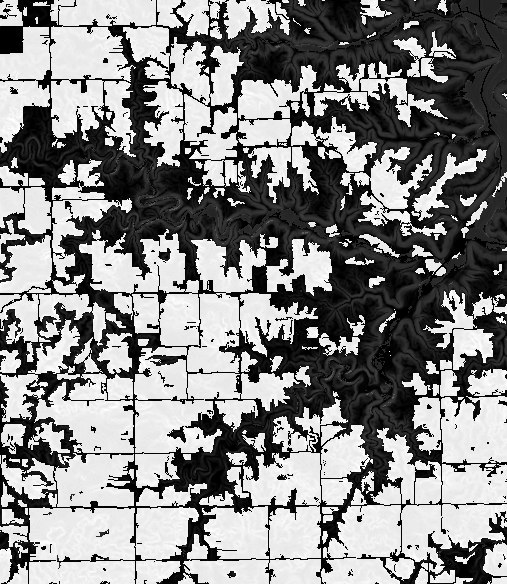

In [45]:
cost_surface

In [46]:
#Generate optimal route
arcpy.sa.OptimalRegionConnections(
    in_regions=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Endpoints",
    out_feature_class=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Optimal_13half",
    in_barrier_data=None,
    in_cost_raster=cost_surface,
    out_neighbor_paths=None,
    distance_method="PLANAR",
    connections_within_regions="GENERATE_CONNECTIONS"
)

<geoprocessing server result object object at 0x00000246BBA488A0>

In [47]:
#Create cost surface where Dory really doesn't want to go through water, but is somewhat okay with farm fields
cost_surface = RasterCalculator(rasters = [rescaled_slope, agricultural, water],
                                input_names = ['x','y','z'],
                                expression = '2*x/9 + y/9 + 6*z/9'
                               )

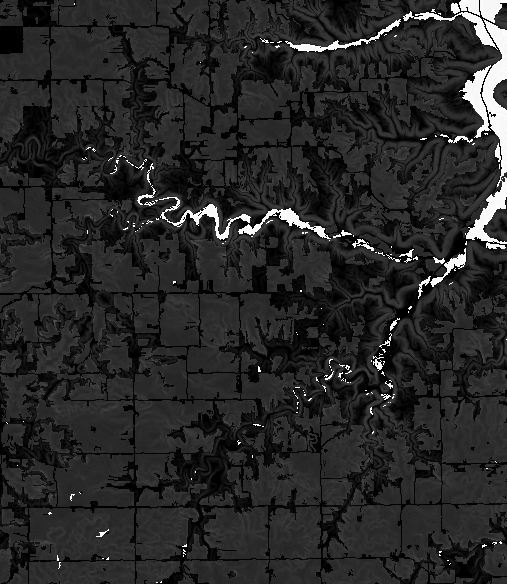

In [48]:
cost_surface

In [49]:
#Generate optimal route
arcpy.sa.OptimalRegionConnections(
    in_regions=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Endpoints",
    out_feature_class=r"C:\Users\tjjoh\Documents\GIS5571\Lab2_GDB.gdb\Optimal_1half3",
    in_barrier_data=None,
    in_cost_raster=cost_surface,
    out_neighbor_paths=None,
    distance_method="PLANAR",
    connections_within_regions="GENERATE_CONNECTIONS"
)

<geoprocessing server result object object at 0x00000246BBA48B70>